# Automatic Run with NEXT

This Notebook uses a pre-trained coefficient estimator to automatically generate temperature estimates for a given watershed.  Right now, the location has to be a USGS gage, but it doesn't have to have stream temperature.

In [1]:
from NEXT import NEXT, full_data

C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
site = "10343500"

In [3]:
nx = NEXT.from_pickle("coefs.pickle")

In [4]:
ws_data = full_data(site, "2020-01-01", "2022-12-31")
ws_data

C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


,id,id_type,lat,lon,area,water,developed,barren,forest,shrubland,...,unknown,ice_snow,elev,slope,elev_min,date,tmax,prcp,srad,vp
0,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.997314,0.000196,1929.513428,2020-01-01,6.995000,0.000000,253.397690,501.099243
1,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.997314,0.000196,1929.513428,2020-01-02,6.326923,0.000000,263.203857,455.838440
2,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.997314,0.000196,1929.513428,2020-01-03,11.920770,0.000000,297.101135,523.626160
3,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.997314,0.000196,1929.513428,2020-01-04,6.115000,0.000000,223.761154,534.477661
4,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.997314,0.000196,1929.513428,2020-01-05,2.720385,0.000000,241.956543,392.126923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.997314,0.000196,1929.513428,2022-12-27,3.190384,39.528847,131.424606,492.266144
1091,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.997314,0.000196,1929.513428,2022-12-28,1.175385,0.000000,210.277313,377.985779
1092,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.997314,0.000196,1929.513428,2022-12-29,2.854615,9.133078,156.367310,437.023865
1093,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.997314,0.000196,1929.513428,2022-12-30,4.925000,74.243462,100.436165,633.595337


In [5]:
nx.make_newt(ws_data)

In [6]:
nx.make_config(f"autoconf_{site}.yaml")

In [7]:
res = nx.run(ws_data)
res

,id,id_type,lat,lon,area,water,developed,barren,forest,shrubland,...,slope,elev_min,date,tmax,prcp,srad,vp,actemp,anom,temp.mod
0,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.000196,1929.513428,2020-01-01,6.995000,0.000000,253.397690,501.099243,4.992950,0.010700,5.003650
1,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.000196,1929.513428,2020-01-02,6.326923,0.000000,263.203857,455.838440,5.016796,0.032154,5.048950
2,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.000196,1929.513428,2020-01-03,11.920770,0.000000,297.101135,523.626160,5.041643,0.128641,5.170284
3,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.000196,1929.513428,2020-01-04,6.115000,0.000000,223.761154,534.477661,5.067427,0.194725,5.262152
4,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.000196,1929.513428,2020-01-05,2.720385,0.000000,241.956543,392.126923,5.094085,0.054274,5.148359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.000196,1929.513428,2022-12-27,3.190384,39.528847,131.424606,492.266144,4.887738,1.207161,6.094900
1091,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.000196,1929.513428,2022-12-28,1.175385,0.000000,210.277313,377.985779,4.840098,0.886105,5.726202
1092,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.000196,1929.513428,2022-12-29,2.854615,9.133078,156.367310,437.023865,4.793852,0.407086,5.200938
1093,10343500,usgs,39.431572,-120.237979,25.25875,0.0,0.000323,0.0,0.970142,0.02611,...,0.000196,1929.513428,2022-12-30,4.925000,74.243462,100.436165,633.595337,4.749015,0.357785,5.106800


<Axes: xlabel='date'>

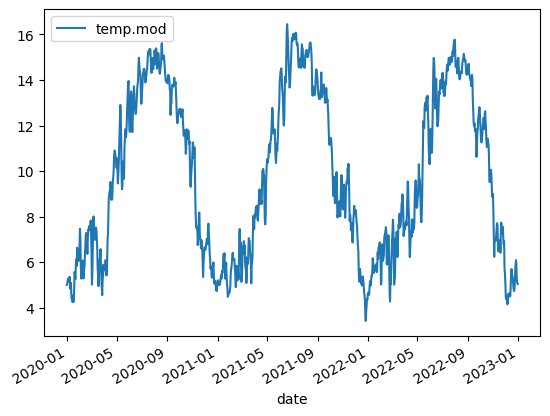

In [8]:
res.plot(x="date", y="temp.mod")